In [6]:
from PIL import Image
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [7]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [8]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is not None:
        width = size.find('width').text
        height = size.find('height').text
        if width and height:
            return int(width), int(height)
    return 0, 0  


def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height


def parse_xml(xml_file, image_file_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    
    width, height = get_image_dimensions(xml_file, image_file_path)


    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        data['filename'].append(filename)
        data['width'].append(width)
        data['height'].append(height)
        data['class'].append(obj_class)
        data['xmin'].append(xmin)
        data['ymin'].append(ymin)
        data['xmax'].append(xmax)
        data['ymax'].append(ymax)


In [9]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, image_size=(416, 416)):
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_size = image_size 
        
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        
        for image_file in self.images:
            xml_file = image_file.replace('.jpg', '.xml')
            xml_path = os.path.join(data_dir, xml_file)
            image_path = os.path.join(data_dir, image_file)
            if os.path.exists(xml_path):
                parse_xml(xml_path, image_path)
        
        self.dataframe = pd.DataFrame(data)

    def __len__(self):
        return len(self.images)
    
    def class_to_label(self, class_name):
        class_mapping = {'apple': 1, 'banana': 2, 'orange': 3, 'mixed': 4}
        return class_mapping.get(class_name, 0) 
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.data_dir, image_name)

        image = cv2.imread(image_path)
        
        # більшість моделей і бібліотек працюють із зображеннями у форматі RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        
        image_data = self.dataframe[self.dataframe['filename'] == image_name]
        for _, row in image_data.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            label = self.class_to_label(row['class'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        
        orig_height, orig_width = image.shape[:2]
        
        #Приведення всіх зображень до одного розміру
        image = cv2.resize(image, self.image_size)
        
        # Коли ми змінюємо розмір зображення, важливо пропорційно змінити й координати bounding boxes
        scale_x = self.image_size[0] / orig_width
        scale_y = self.image_size[1] / orig_height
        boxes = [[xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y] for xmin, ymin, xmax, ymax in boxes]
        
        boxes = [[xmin / self.image_size[0], ymin / self.image_size[1], xmax / self.image_size[0], ymax / self.image_size[1]] for xmin, ymin, xmax, ymax in boxes]

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        return image, target


In [13]:
transform = A.Compose([
    
    # Дзеркально відображає зобреження, щоб в подальшому модель звикала до симетрії(обʼєкт може бути як ліворуч так і праворуч)
    A.HorizontalFlip(p=0.5),
    # Перевертає зображення щоб якщо обʼєкти були перевернутими, або нахиленимим, модель всеодно їх впізнавала
    A.Rotate(limit=15, p=0.5),
    # Допомагає моделі розпізнавати обʼєкти не залежно від умов освітлення
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    # моделі в PyTorch очікують вхідні дані у вигляді тензорів
    ToTensorV2(p=1.0),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

dataset = FruitDataset(data_dir='/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/train_zip/train', transforms=transform, image_size=(512, 512))

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

for images, targets in dataloader:
    print(images[0].shape, targets[0]['boxes'])

torch.Size([3, 512, 512]) tensor([[0.3304, 0.0494, 0.7712, 0.9754],
        [0.3304, 0.0494, 0.7712, 0.9754]])
torch.Size([3, 512, 512]) tensor([[0.0505, 0.1014, 0.9620, 1.0000],
        [0.0505, 0.1014, 0.9620, 1.0000]])
torch.Size([3, 512, 512]) tensor([[0.3258, 0.0956, 0.7581, 0.8114],
        [0.3258, 0.0956, 0.7581, 0.8114]])
torch.Size([3, 512, 512]) tensor([[0.1360, 0.1886, 0.9041, 0.9016],
        [0.1360, 0.1886, 0.9041, 0.9016]])
torch.Size([3, 512, 512]) tensor([[0.3164, 0.3057, 0.6758, 0.7143],
        [0.3164, 0.3057, 0.6758, 0.7143]])
torch.Size([3, 512, 512]) tensor([[0.4275, 0.1995, 0.8763, 1.0000],
        [0.2200, 0.0938, 0.7675, 0.9183],
        [0.1625, 0.0192, 0.7437, 0.5433],
        [0.4275, 0.1995, 0.8763, 1.0000],
        [0.2200, 0.0938, 0.7675, 0.9183],
        [0.1625, 0.0192, 0.7437, 0.5433]])
torch.Size([3, 512, 512]) tensor([[0.0292, 0.1360, 0.7823, 0.8518],
        [0.0292, 0.1360, 0.7823, 0.8518]])
torch.Size([3, 512, 512]) tensor([[0.2226, 0.1387, 0.73

libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 512, 512]) tensor([[0.2212, 0.3952, 0.7628, 0.9095],
        [0.2212, 0.3952, 0.7628, 0.9095]])
torch.Size([3, 512, 512]) tensor([[0.0000, 0.4568, 0.9287, 0.9336],
        [0.0000, 0.4568, 0.9287, 0.9336]])
torch.Size([3, 512, 512]) tensor([[0.5446, 0.0688, 0.9638, 0.5081],
        [0.5446, 0.0688, 0.9638, 0.5081]])
torch.Size([3, 512, 512]) tensor([[0.0576, 0.2125, 0.8597, 0.9811],
        [0.0576, 0.2125, 0.8597, 0.9811]])


libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 512, 512]) tensor([[0.0039, 0.1357, 0.9599, 0.9805],
        [0.0039, 0.1357, 0.9599, 0.9805]])
torch.Size([3, 512, 512]) tensor([[0.3593, 0.2001, 0.9832, 0.8378],
        [0.0611, 0.1254, 0.6231, 0.6675],
        [0.3593, 0.2001, 0.9832, 0.8378],
        [0.0611, 0.1254, 0.6231, 0.6675]])
torch.Size([3, 512, 512]) tensor([[0.0391, 0.1134, 0.5608, 0.7567],
        [0.0391, 0.1134, 0.5608, 0.7567]])
torch.Size([3, 512, 512]) tensor([[0.0628, 0.0780, 0.4745, 0.6526],
        [0.0628, 0.0780, 0.4745, 0.6526]])
torch.Size([3, 512, 512]) tensor([[0.2715, 0.2490, 0.9477, 0.9722],
        [0.2715, 0.2490, 0.9477, 0.9722]])
torch.Size([3, 512, 512]) tensor([[0.5590, 0.2852, 0.9552, 0.8047],
        [0.3049, 0.3817, 0.7604, 0.8969],
        [0.1675, 0.3567, 0.5519, 0.8447],
        [0.2295, 0.0412, 0.6961, 0.5673],
        [0.5590, 0.2852, 0.9552, 0.8047],
        [0.3049, 0.3817, 0.7604, 0.8969],
        [0.1675, 0.3567, 0.5519, 0.8447],
        [0.2295, 0.0412, 0.6961, 0.5673]]

torch.Size([3, 512, 512]) tensor([[0.3644, 0.3696, 1.0000, 0.9526],
        [0.4665, 0.5486, 0.9931, 1.0000],
        [0.0298, 0.1014, 0.8338, 0.8937],
        [0.3644, 0.3696, 1.0000, 0.9526],
        [0.4665, 0.5486, 0.9931, 1.0000],
        [0.0298, 0.1014, 0.8338, 0.8937]])
torch.Size([3, 512, 512]) tensor([[0.2100, 0.1509, 0.9100, 0.9748],
        [0.2100, 0.1509, 0.9100, 0.9748]])
torch.Size([3, 512, 512]) tensor([[0.4280, 0.4800, 0.7720, 0.8320],
        [0.3320, 0.4280, 0.6440, 0.7920],
        [0.4280, 0.4800, 0.7720, 0.8320],
        [0.3320, 0.4280, 0.6440, 0.7920]])
torch.Size([3, 512, 512]) tensor([[0.1496, 0.1778, 0.9154, 0.9506],
        [0.1496, 0.1778, 0.9154, 0.9506]])
torch.Size([3, 512, 512]) tensor([[0.1278, 0.3489, 0.8192, 0.8076],
        [0.1278, 0.3489, 0.8192, 0.8076]])
torch.Size([3, 512, 512]) tensor([[0.0000, 0.0900, 0.9053, 0.8876],
        [0.1620, 0.1602, 1.0000, 1.0000],
        [0.0000, 0.0662, 0.8507, 0.6233],
        [0.0000, 0.0900, 0.9053, 0.8876],

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [14]:
def visualize_image_with_boxes(image, target):
    image_np = image.permute(1, 2, 0).numpy() * 255
    image_np = image_np.astype('uint8')

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    boxes = target["boxes"]
    labels = target["labels"]
    
    for i in range(boxes.shape[0]):
        box = boxes[i]
        label = labels[i].item()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"Label: {label}", color='white', fontsize=12, backgroundcolor='red')

    plt.show()

def visualize_some_images_with_boxes(dataloader, num_images=5):
    count = 0
    for images, targets in dataloader:
        for i in range(len(images)):
            visualize_image_with_boxes(images[i], targets[i])
            count += 1
            if count >= num_images:
                return

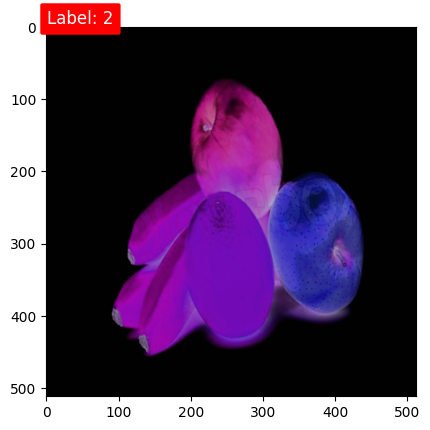

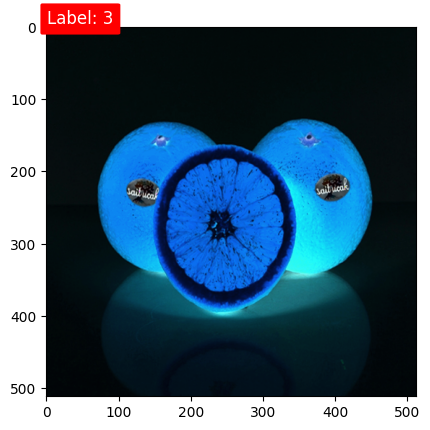

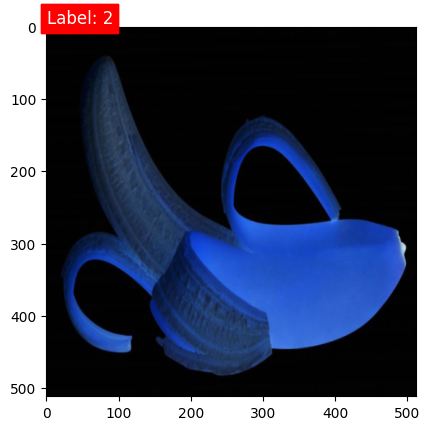

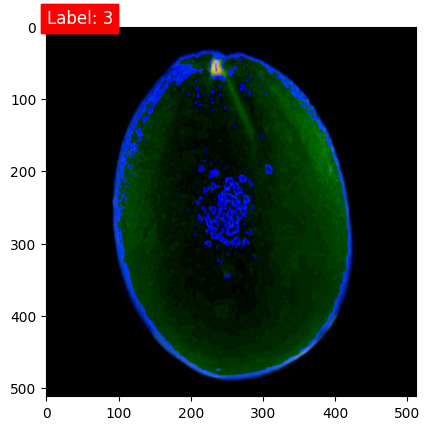

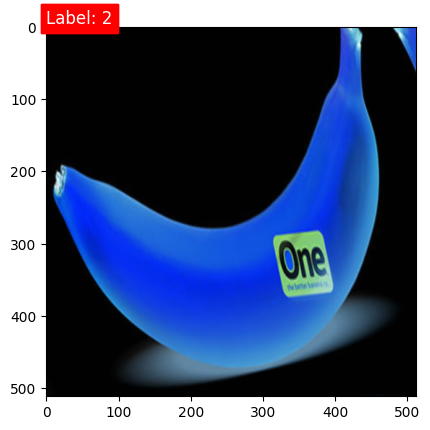

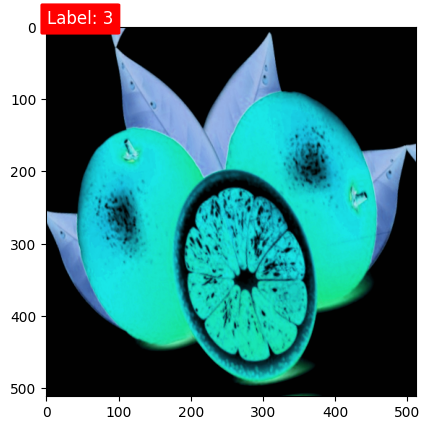

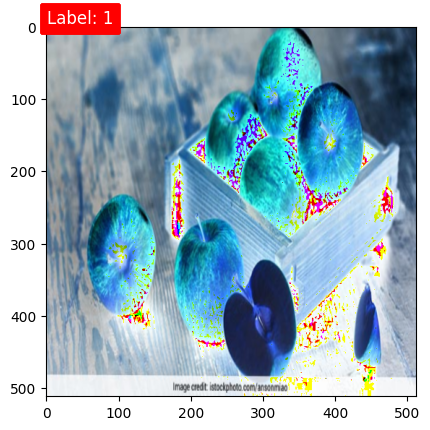

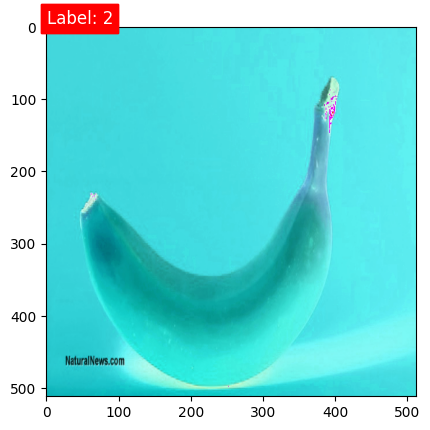

libpng warning: iCCP: known incorrect sRGB profile


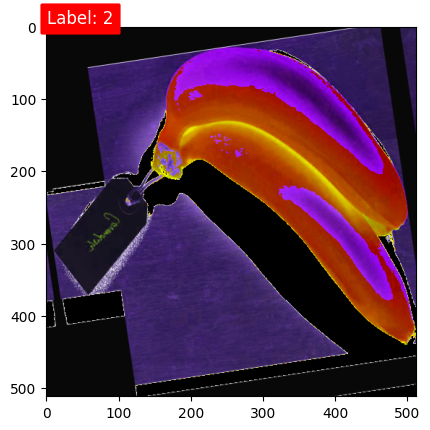

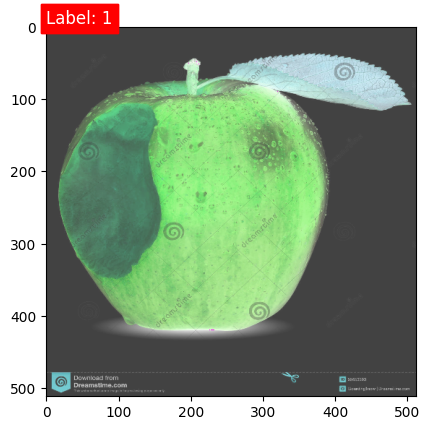

In [15]:
visualize_some_images_with_boxes(dataloader, num_images=10)